[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/git-sunao/path-integral/blob/main/notebooks/test12.ipynb)

In [1]:
# Run this if in Google Colab
# !git clone https://github.com/git-sunao/path-integral.git
# %cd path-integral
# !pip install -r requirements.txt

In [2]:
# general
import os
import numpy as np
from tqdm import tqdm
# jax
import jax
import jax.numpy as jnp
import jax.scipy as jsp
from jax import jit
from jax import grad
from jax import vmap
from jax import jacobian
from jax import jacfwd, jacrev
from jax import vjp
from jax.lax import scan
from jax.experimental.ode import odeint
# plotting
import matplotlib.pyplot as plt
import arviz
from getdist import plots, MCSamples
# numpyro
import numpyro
import numpyro.distributions as npyro_dist
from numpyro.infer import MCMC, NUTS
# NF
import torch
import pyro
import pyro.distributions as pyro_dist
import pyro.distributions.transforms as T
smoke_test = ('CI' in os.environ)
%matplotlib inline
cpu_device = jax.devices('cpu')[0]

/Users/sugiyamasunao/miniconda3/envs/pyplint/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Development notebook 12

$\providecommand{\d}{\mathrm{d}}$
$\providecommand{\D}{\mathcal{D}}$


In [151]:
def action_iphi(z, y, w):
    z2 = jnp.dot(z, z)
    zy = jnp.dot(z, y)
    # iphi = 1j*(z2 - 2*zy) + 10 * 1j/(1+z2)
    iphi = 1j*(z2 - 2*zy) + 10 * 1j/(1+z2)
    return w*iphi

def action_h(z, y, w):
    s = action_iphi(z, y, w)
    h = jnp.real(s) + 0.0j
    return h

def action_Seff(z, y, w):
    seff = -action_iphi(z, y, w)
    return seff

def integrand(z, y, w):
    return jnp.exp(action_iphi(z, y, w))

# vector
vintegrand = jax.vmap(integrand, (0,None,None), 0)

# corresponding gradients
grad_iphi = grad(action_iphi, holomorphic=True)
grad_h    = grad(action_h, holomorphic=True)
grad_Seff = grad(action_Seff, holomorphic=True)
# Hessians
hess_Seff = jax.hessian(action_Seff, holomorphic=True, argnums=0)

In [152]:
def flow_step(z, y, ds, w):
    dSdz = grad_Seff(z, y, w)
    v = jnp.conj(dSdz)
    # If integrand is already small we do not 
    # have to move the point, so we multiply 
    # the velocity by the size of the integrand 
    # We can safely choose the typical norm of the
    # integrand to be unity, because in PL theory
    # the amplitude of the integrand always decays 
    # as a function of flow time from unity.
    i = integrand(z, y, w)
    dz= ds*v*jnp.abs(i)
    z = z + dz
    return z

vflow_step  = vmap(flow_step, (0,None,None,None), 0)

def flow(z, y=0.0, w=1, tmax=1.0, nt=10):
    t = jnp.linspace(0, tmax, nt)

    def velocity(z,t,y,w):
        dSdz = grad_Seff(z, y, w)
        v = jnp.conj(dSdz)
        # If integrand is already small we do not 
        # have to move the point, so we multiply 
        # the velocity by the size of the integrand 
        # We can safely choose the typical norm of the
        # integrand to be unity, because in PL theory
        # the amplitude of the integrand always decays 
        # as a function of flow time from unity.
        i = integrand(z, y, w)
        return v*jnp.abs(i)

    def single_ode_solver(z0, y, w):
        args = (y,w)
        z_traj = odeint(velocity, z0, t, *args)
        return z_traj[-1]

    zs_final = jax.vmap(single_ode_solver, (0,None,None), 0)(z, y, w)
    return zs_final


In [153]:
%%time
ndim = 1
n_samples = 100
x = jnp.linspace(-3,3,n_samples)
z = x.astype(complex).reshape(n_samples, ndim)
y = jnp.zeros(ndim)

w = 1.0
i0= vintegrand(z, y, w)

# Flow
n_steps = int(30*w)
for i in range(n_steps):
    z = vflow_step(z, y, 1e-2, w)

iz= vintegrand(z, y, w)

CPU times: user 375 ms, sys: 7.37 ms, total: 383 ms
Wall time: 391 ms


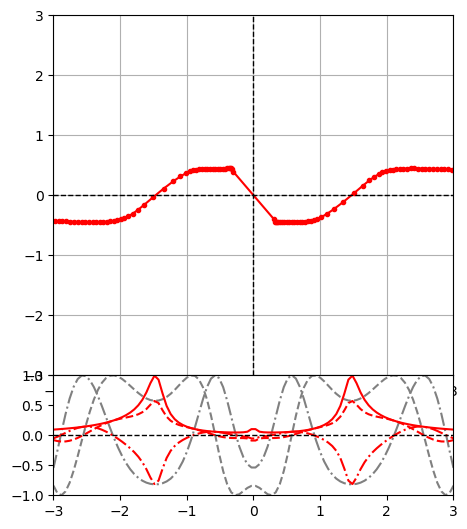

In [154]:
# Plot
fig = plt.figure(figsize=(5,6))
ax1 = fig.add_axes((.1,.3,.8,.6))
ax1.plot(z.real, z.imag, color='red', marker='.')
ax1.set_xlim(x.min(),x.max())
ax1.set_ylim(x.min(),x.max())
ax1.axhline(0, color='black', lw=1, ls='--')
ax1.axvline(0, color='black', lw=1, ls='--')
ax1.grid()
ax1.set_xlabel('')
ax2 = fig.add_axes((.1,.1,.8,.2), sharex=ax1)
ax2.plot(x, jnp.real(i0), color='gray', ls='--')
ax2.plot(x, jnp.imag(i0), color='gray', ls='-.')
ax2.plot(x, jnp.abs(i0) , color='gray', ls='-' )
ax2.plot(x, jnp.real(iz), color='red' , ls='--')
ax2.plot(x, jnp.imag(iz), color='red' , ls='-.')
ax2.plot(x, jnp.abs(iz) , color='red' , ls='-' )
ax2.axhline(0., color='black', lw=1, ls='--')
ax2.set_ylim(-1.0, 1.0)
plt.show()

In [ ]:
%%time
ndim = 1
n_samples = 1000
x = jnp.linspace(-3,3,n_samples)
z = x.astype(complex).reshape(n_samples, ndim)
y = jnp.zeros(ndim)

w = 1.0
i0= vintegrand(z, y, w)

# Flow
z = flow(z, y=y, w=w, tmax=2*w, nt=10)

iz= vintegrand(z, y, w)

CPU times: user 894 ms, sys: 32.3 ms, total: 926 ms
Wall time: 939 ms


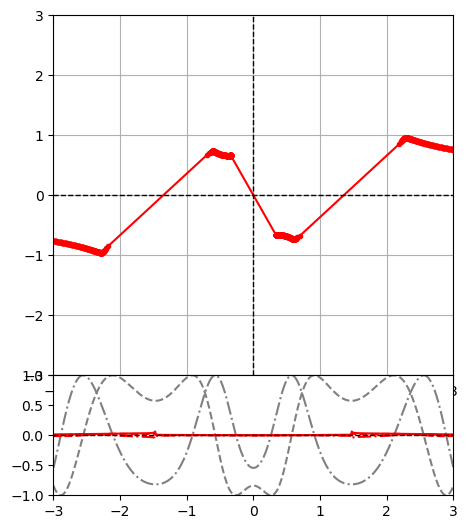

In [146]:
# Plot
fig = plt.figure(figsize=(5,6))
ax1 = fig.add_axes((.1,.3,.8,.6))
ax1.plot(z.real, z.imag, color='red', marker='.')
ax1.set_xlim(x.min(),x.max())
ax1.set_ylim(x.min(),x.max())
ax1.axhline(0, color='black', lw=1, ls='--')
ax1.axvline(0, color='black', lw=1, ls='--')
ax1.grid()
ax1.set_xlabel('')
ax2 = fig.add_axes((.1,.1,.8,.2), sharex=ax1)
ax2.plot(x, jnp.real(i0), color='gray', ls='--')
ax2.plot(x, jnp.imag(i0), color='gray', ls='-.')
ax2.plot(x, jnp.abs(i0) , color='gray', ls='-' )
ax2.plot(x, jnp.real(iz), color='red' , ls='--')
ax2.plot(x, jnp.imag(iz), color='red' , ls='-.')
ax2.plot(x, jnp.abs(iz) , color='red' , ls='-' )
ax2.axhline(0., color='black', lw=1, ls='--')
ax2.set_ylim(-1.0, 1.0)
plt.show()

In [130]:
def flow(z, y=0.0, w=1, tmax=1.0, nt=100):
    t = jnp.linspace(0, tmax, nt)

    def velocity(z,t,y,w):
        dsdz = jnp.conj(grad_Seff(z, y, w))
        i = integrand(z, y, w)
        # if integrand is already small we do not 
        # have to move the point, so we multiply 
        # the velocity by the size of the integrand
        # Here we assume typical size of the integrand
        # to be unity.
        v = dsdz*jnp.abs(i)
        return v

    def single_ode_solver(z0, y, w):
        args = (y,w)
        z_traj = odeint(velocity, z0, t, *args)
        return z_traj[-1]

    zs_final = jax.vmap(single_ode_solver, (0,None,None), 0)(z, y, w)
    return zs_final

In [136]:
%%time
ndim = 1
n_samples = 200
x = jnp.linspace(-3,3,n_samples)
z = x.astype(complex).reshape(n_samples, ndim)
y = jnp.zeros(ndim)

w = 0.2
i0= vintegrand(z, y, w)

# Flow
zt= flow(z, y, w, tmax=0.1, nt=100)
iz= vintegrand(zt, y, w)

CPU times: user 1.01 s, sys: 39.9 ms, total: 1.04 s
Wall time: 1.14 s


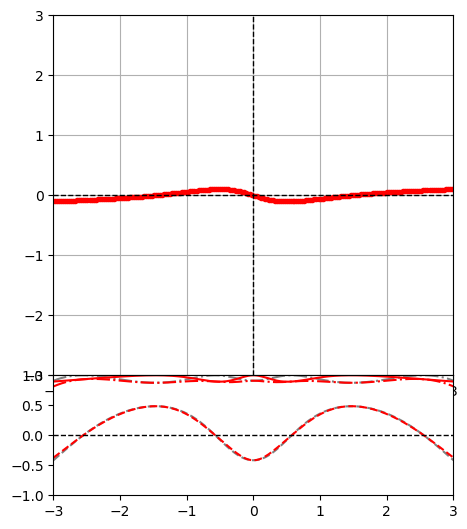

In [137]:
# Plot
fig = plt.figure(figsize=(5,6))
ax1 = fig.add_axes((.1,.3,.8,.6))
ax1.plot(zt.real, zt.imag, color='red', marker='.')
ax1.set_xlim(x.min(),x.max())
ax1.set_ylim(x.min(),x.max())
ax1.axhline(0, color='black', lw=1, ls='--')
ax1.axvline(0, color='black', lw=1, ls='--')
ax1.grid()
ax1.set_xlabel('')
ax2 = fig.add_axes((.1,.1,.8,.2), sharex=ax1)
ax2.plot(x, jnp.real(i0), color='gray', ls='--')
ax2.plot(x, jnp.imag(i0), color='gray', ls='-.')
ax2.plot(x, jnp.abs(i0) , color='gray', ls='-' )
ax2.plot(x, jnp.real(iz), color='red' , ls='--')
ax2.plot(x, jnp.imag(iz), color='red' , ls='-.')
ax2.plot(x, jnp.abs(iz) , color='red' , ls='-' )
ax2.axhline(0., color='black', lw=1, ls='--')
ax2.set_ylim(-1.0, 1.0)
plt.show()

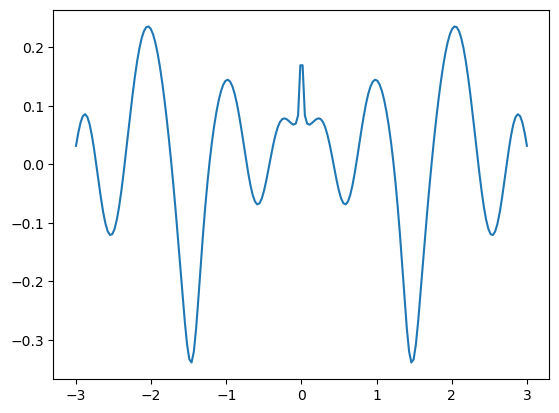

In [133]:
plt.plot(x, iz.real)

In [47]:
def flow(z, y=0.0, w=1, t_max=10.0, nt=100):
    tm = jnp.linspace(0, t_max, nt)

    def single_ode_solver(z0):
        z_traj = odeint(lambda x, t: jnp.conj(grad_Seff(x, y, w)), z0, tm)
        return z_traj

    zs_final = jax.vmap(single_ode_solver)(z)
    return zs_final

In [48]:
%%time
ndim = 1
n_samples = 100
x = jnp.linspace(-3,3,n_samples)
z = x.astype(complex).reshape(n_samples, ndim)
y = jnp.zeros(ndim)

w = 1.0
i0= vintegrand(z, y, w)

# Flow
zt= flow(z, y, w, nt=10)

CPU times: user 926 ms, sys: 30.7 ms, total: 956 ms
Wall time: 954 ms


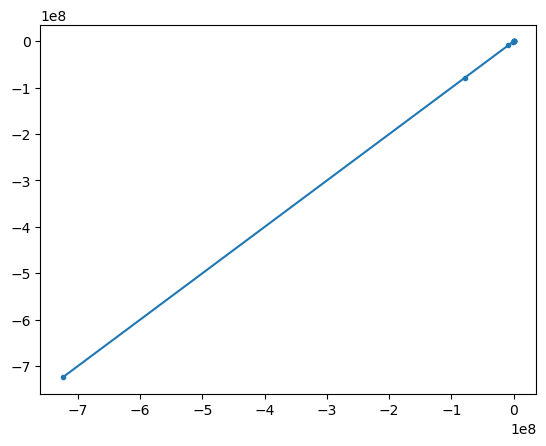

In [49]:
plt.plot(zt[0,:,0].real, zt[0,:,0].imag, marker='.')

In [43]:
?odeint

Signature:
odeint(
    func,
    y0,
    t,
    *args,
    rtol=1.4e-08,
    atol=1.4e-08,
    mxstep=inf,
    hmax=inf,
)
Docstring:
Adaptive stepsize (Dormand-Prince) Runge-Kutta odeint implementation.

Args:
  func: function to evaluate the time derivative of the solution `y` at time
    `t` as `func(y, t, *args)`, producing the same shape/structure as `y0`.
  y0: array or pytree of arrays representing the initial value for the state.
  t: array of float times for evaluation, like `jnp.linspace(0., 10., 101)`,
    in which the values must be strictly increasing.
  *args: tuple of additional arguments for `func`, which must be arrays
    scalars, or (nested) standard Python containers (tuples, lists, dicts,
    namedtuples, i.e. pytrees) of those types.
  rtol: float, relative local error tolerance for solver (optional).
  atol: float, absolute local error tolerance for solver (optional).
  mxstep: int, maximum number of steps to take for each timepoint (optional).
  hmax: float, max

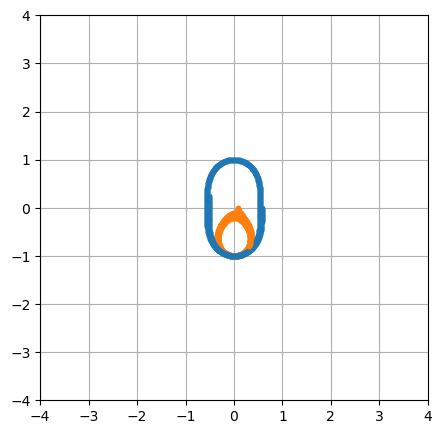

In [46]:
ndim = 1
n_samples = 50
z = x = jnp.array([jnp.linspace(-4, 4, n_samples)]*ndim, dtype=complex).T
y = jnp.zeros_like(z)

plt.figure(figsize=(5,5))
n_steps = 800
for i in range(n_steps):
    plt.plot(z[28,:].real, z[28,:].imag, alpha=1, color='C0', marker='.')
    plt.plot(z[25,:].real, z[25,:].imag, alpha=1, color='C1', marker='.')
    z = vflow1(z, y, 0.01)
plt.ylim(-4,4)
plt.xlim(-4,4)
plt.grid()
plt.show()

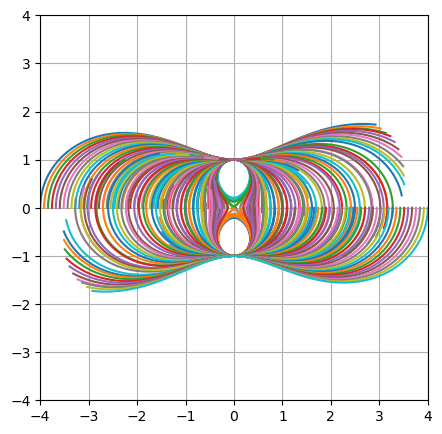

In [47]:
ndim = 1
n_samples = 100
z = x = jnp.array([jnp.linspace(-4, 4, n_samples)]*ndim, dtype=complex).T
y = jnp.zeros_like(z)

z_samples = []
for i in range(n_steps):
    z_samples.append(z)
    z = vflow1(z, y, 0.01)

z = jnp.hstack(z_samples)
del z_samples

plt.figure(figsize=(5,5))
for i in range(n_samples):
    plt.plot(z[i,:].real, z[i,:].imag)
plt.ylim(-4,4)
plt.xlim(-4,4)
plt.grid()
plt.show()

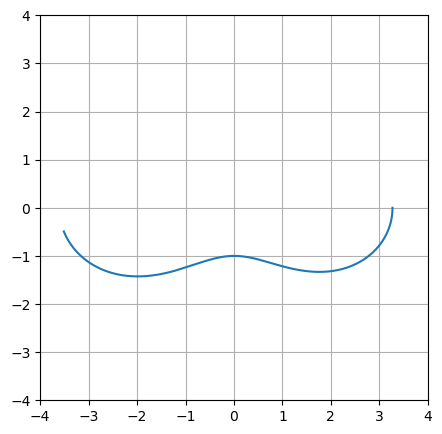

In [48]:
plt.figure(figsize=(5,5))
i = 90
plt.plot(z[i,:].real, z[i,:].imag)
plt.ylim(-4,4)
plt.xlim(-4,4)
plt.grid()
plt.show()

In [78]:
N = 50+1
zr = jnp.linspace(-2., 2., N)
zi = jnp.linspace(-2., 2., N)
Zr, Zi = jnp.meshgrid(zr, zi)
Z = Zr + 1j*Zi
Z = Z.ravel()

In [88]:
seff = vgrad_Seff(jnp.array([Z]).T, jnp.zeros_like(jnp.array([Z]).T))
seff = seff.reshape(N,N)

sana = 2j*Z/(1+Z**2)**2
sana = sana.reshape(N,N)

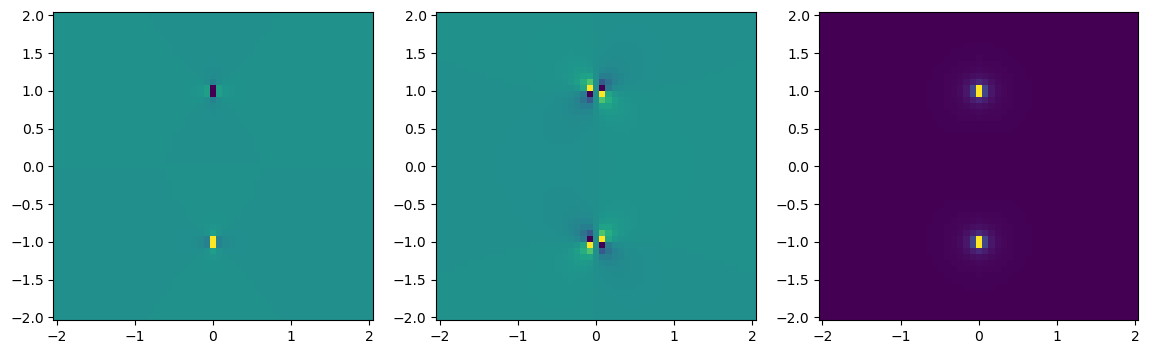

In [90]:
fig, axes = plt.subplots(1,3,figsize=(14,4))
ax = axes[0]
ax.pcolormesh(zr, zi, seff.real)
ax = axes[1]
ax.pcolormesh(zr, zi, seff.imag)
ax = axes[2]
ax.pcolormesh(zr, zi, jnp.abs(seff))
plt.show()

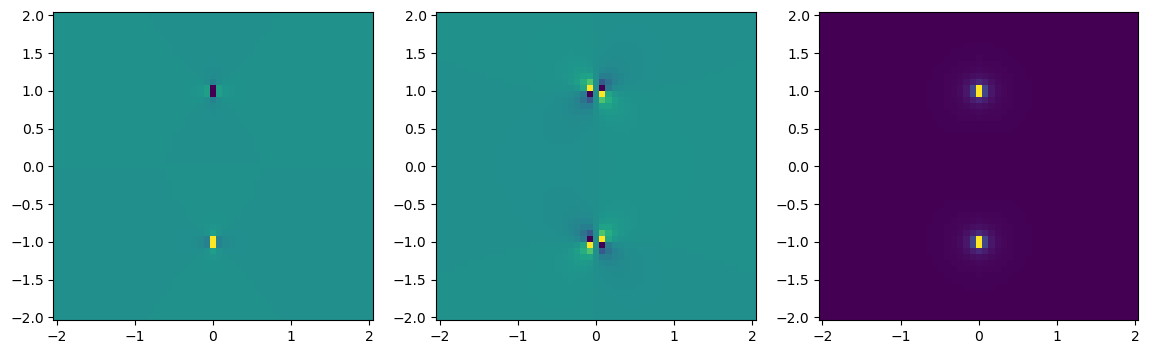

In [91]:
fig, axes = plt.subplots(1,3,figsize=(14,4))
ax = axes[0]
ax.pcolormesh(zr, zi, sana.real)
ax = axes[1]
ax.pcolormesh(zr, zi, sana.imag)
ax = axes[2]
ax.pcolormesh(zr, zi, jnp.abs(sana))
plt.show()